<a href="https://colab.research.google.com/github/jupastro/CNNs/blob/main/Fly_Wing_segmentation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **U-Net-like architecture for Fly Wing segmentation in 2D**

---


## Introduction
This notebook aims at being a playground to study U-Net-like architectures for semantic segmentation in 2D as well as the use of Self-Supervised Learning(SSL) pre-text tasks to enhance performance under reduced availability of annotated images. 

In particular, we will show how to perform binary segmentation  microscopy images. The main idea is to study how the percentage of data used during the training affects to the final performance of the model


## Data

The data used is a public available set from the Denoiseg paper(https://arxiv.org/abs/2005.02987) available at https://github.com/juglab/DenoiSeg.

This dataset  consist of 1428 training and 252 validation patches of a membrane labeled fly wing. The test set is comprised of 42 additional complete images.



## Getting started
---



#### **Setting the seed for reproducibility**

The first steps in any deep learning study must be to set up the environment and to ensure as much as possible the reproducibility of the results.

We're going to ensure the use of Tensorflow 2.x version so that we won't have any incompatibilities with our code.

In [1]:
# Make sure TF 2 is used
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
#load the required example functions from pix2pix tf.pack
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import os
import random
def set_seed(seedValue=42):
  """Sets the seed on multiple python modules to obtain results as
  reproducible as possible.
  Args:
  seedValue (int, optional): seed value.
  """
  random.seed(a=seedValue)
  np.random.seed(seed=seedValue)
  tf.random.set_seed(seedValue)
  os.environ["PYTHONHASHSEED"]=str(seedValue)
set_seed()

print( tf.__version__ )

2.4.1


#### **Downloading the data**
Then, we will download the already patched images provided by the https://github.com/juglab/DenoiSeg group to be able to compare our results as much as possible to theirs.

In [3]:
!wget 'https://owncloud.mpi-cbg.de/index.php/s/liMinMlacVYnldB/download'
!unzip download

--2021-03-25 11:08:32--  https://owncloud.mpi-cbg.de/index.php/s/liMinMlacVYnldB/download
Resolving owncloud.mpi-cbg.de (owncloud.mpi-cbg.de)... 141.5.10.73
Connecting to owncloud.mpi-cbg.de (owncloud.mpi-cbg.de)|141.5.10.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download’

download                [       <=>          ]  47.39M  32.5MB/s    in 1.5s    

2021-03-25 11:08:34 (32.5 MB/s) - ‘download’ saved [49691925]

Archive:  download
   creating: Flywing_n0/
   creating: Flywing_n0/test/
 extracting: Flywing_n0/test/test_data.npz  
   creating: Flywing_n0/train/
 extracting: Flywing_n0/train/train_data.npz  


As the data is loaded in .npz format it would be necessary to load it to further work on it.

In [4]:
#Loading train and validation splits
trainval_data =  np.load('Flywing_n0/train/train_data.npz')
train_img = trainval_data['X_train'].astype(np.float32)
train_lbl = trainval_data['Y_train']
val_img = trainval_data['X_val'].astype(np.float32)
val_lbl = trainval_data['Y_val']

Now we will check the number of images and masks:

Shape of train_images: (1428, 128, 128)
Shape of train_masks:  (1428, 128, 128)
Shape of val_images:   (252, 128, 128)
Shape of val_masks:    (252, 128, 128)


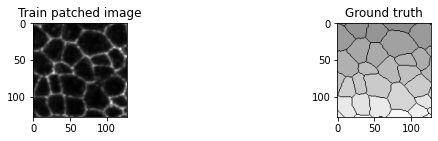

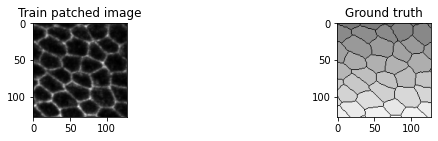

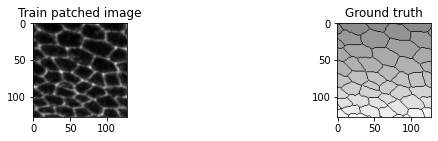

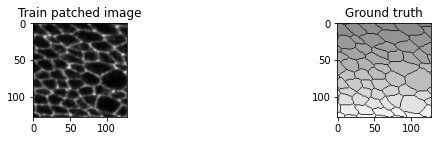

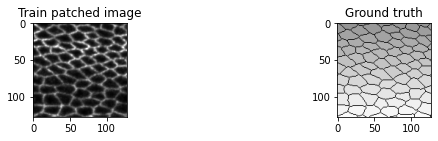

In [5]:
from skimage.util import img_as_ubyte
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize
# read training images and labels
# read training images and labels


for i in range(1,6):
  plt.figure(figsize=(10,10))
  plt.subplot(5, 2, i*2-1)
  plt.imshow( train_img[i-1],'gray' )
  plt.title( 'Train patched image' )
  # Side by side with its "ground truth"
  plt.subplot(5, 2, i*2)
  plt.imshow( train_lbl[i-1],'gray' )
  plt.title( 'Ground truth' )

print("Shape of train_images: {}".format(train_img.shape))
print("Shape of train_masks:  {}".format(train_lbl.shape))
print("Shape of val_images:   {}".format(val_img.shape))
print("Shape of val_masks:    {}".format(val_lbl.shape))

Shape of test_imgs:   (42, 512, 512)
Shape of test_imgs:    (42, 512, 512)


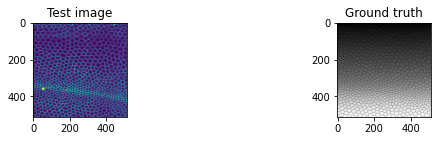

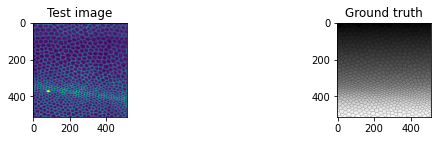

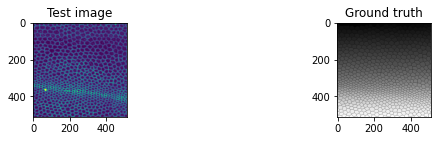

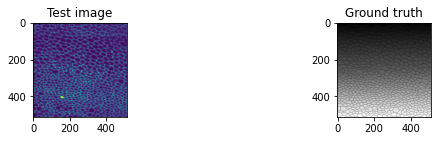

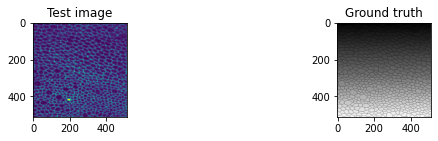

In [6]:
test_data =  np.load('Flywing_n0/test/test_data.npz',allow_pickle=True)
test_img = test_data['X_test']
test_lbl = test_data['Y_test']

# Display corresponding first patch at low resolution
for i in range(1,6):
  plt.figure(figsize=(10,10))
  plt.subplot(5, 2, i*2-1)
  plt.imshow( test_img[i-1] )
  plt.title( 'Test image' )
  # Side by side with its "ground truth"
  plt.subplot(5, 2, i*2)
  plt.imshow( test_lbl[i-1], 'gray' )
  plt.title( 'Ground truth' )
print("Shape of test_imgs:   {}".format(test_img.shape))
print("Shape of test_imgs:    {}".format(test_lbl.shape))

As we can observe the data set is splitted into:
* 1428 128x128 training patches
* 252 128x128 validation patches 
* 42 complete images 512x512 for testing

## Preparing the training data
In this steps normally a cropping of the images is performed but as they have already been cropped we will:

* Reduce the number of images to test the influence in the performance.

* Induce some noise in the images to perform a pretraining step.

* Prepare the data_augmentation to be performed.


Created list with 1428 images
Created list with 252 images


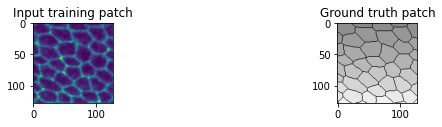

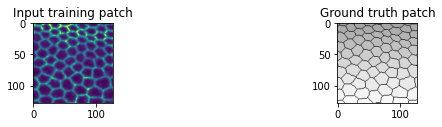

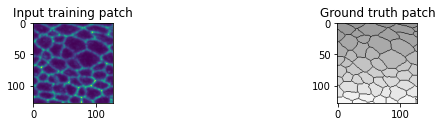

In [7]:
import random
percentage_data=1 #parameter to be changed in between 0-1 to reduce  randomly the number of annotated patches to be used during training
def reduce_number_imgs(imgs,label_imgs,percentage_data=1,normalize=True):
    
    n=len(imgs)
    if normalize:
      idx=random.sample(list(range(0,n)),int(n*percentage_data))
      x= [imgs[i]/255. for i in idx] 
      y= [label_imgs[i] for i in idx] 
    else:
      idx=random.sample(list(range(0,n)),int(n*percentage_data))
      x= [imgs[i] for i in idx] 
      y= [label_imgs[i] for i in idx] 
    print('Created list with '+str(len(x))+' images')
   
    return x,y
train_img_patches,train_lbl_patches=reduce_number_imgs(train_img,train_lbl,percentage_data=percentage_data)

for i in range(0,3):
  plt.figure(figsize=(10,5))
  plt.subplot(3, 2, 1)
  plt.imshow( train_img_patches[i] )
  plt.title( 'Input training patch' );
  # and its "ground truth"
  plt.subplot(3, 2, 2)
  plt.imshow( train_lbl_patches[i] ,'gray')
  plt.title( 'Ground truth patch' );
val_img_patches,val_lbl_patches=reduce_number_imgs(val_img,val_lbl,percentage_data=percentage_data)




In [8]:
import numpy as np
import matplotlib.pyplot as plt

def add_Gaussian_Noise(image,percentage_of_noise,print_img=False):
  """
  image: greyscale image to be added Gaussian Noise with 0 mean and a certain std
  percentage_of_noise:similar to 1/SNR, it represents the % of 
  the maximum value of the image that will be used as the std of the Gaussian Noise distribution
  """
  max_value=np.max(image)
  noise_level=percentage_of_noise*max_value
  Noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
  noisy_img=np.clip(image+Noise,0,max_value)  
  if print_img:
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow( image )
    plt.title( 'Original image' );
    # and its "ground truth"
    plt.subplot(1, 2, 2)
    plt.imshow( noisy_img )
    plt.title( 'Noisy image' );
  
  return noisy_img
noisy_train_img=[]
for x in train_img:
  noisy_train_img.append(add_Gaussian_Noise(x,0.12,print_img=False) )
# We will use these patches as "ground truth" for the pretraining step

Now we are going to reduce the number of annotated images used for training. This is meant to simulate the case where few annotated images are available as they often require from expert labelling but there's available a bunch of same-context non-annotated images. 

In [9]:
#create dif% patches
train_img_patches1,train_lbl_patches1=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.0027)
train_img_patches2,train_lbl_patches2=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.005)
train_img_patches3,train_lbl_patches3=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.01)
train_img_patches4,train_lbl_patches4=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.02)
train_img_patches5,train_lbl_patches5=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.04)
train_img_patches6,train_lbl_patches6=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.08)
train_img_patches7,train_lbl_patches7=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.16)
train_img_patches8,train_lbl_patches8=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.32)
train_img_patches9,train_lbl_patches9=reduce_number_imgs(train_img_patches,train_lbl_patches,percentage_data=0.64)


Created list with 3 images
Created list with 7 images
Created list with 14 images
Created list with 28 images
Created list with 57 images
Created list with 114 images
Created list with 228 images
Created list with 456 images
Created list with 913 images


In [10]:
#create dif% patches
val_img_patches1,val_lbl_patches1=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.0027)
val_img_patches2,val_lbl_patches2=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.005)
val_img_patches3,val_lbl_patches3=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.01)
val_img_patches4,val_lbl_patches4=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.02)
val_img_patches5,val_lbl_patches5=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.04)
val_img_patches6,val_lbl_patches6=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.08)
val_img_patches7,val_lbl_patches7=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.16)
val_img_patches8,val_lbl_patches8=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.32)
val_img_patches9,val_lbl_patches9=reduce_number_imgs(val_img_patches,val_lbl_patches,percentage_data=0.64)


Created list with 0 images
Created list with 1 images
Created list with 2 images
Created list with 5 images
Created list with 10 images
Created list with 20 images
Created list with 40 images
Created list with 80 images
Created list with 161 images


## Evaluation metrics
To evaluate the segmentation performance, we will use the [Jaccard index or Intersection over the Union](https://en.wikipedia.org/wiki/Jaccard_index), after thresholding the outputs using 0.5 as threshold value. 

It is also worth noting that this function works over the border and cell GT, as the background is normally quite constant and can influence the metric value without really being indicative of the actual performance of the U-Net model.

In [11]:
import tensorflow as tf

def jaccard_index( y_true, y_pred, skip_first_mask=False ):
    ''' Define Jaccard index for multiple labels.
        Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.
            skip_background (bool, optional): skip 0-label from calculation.
        Return:
            jac (tensor): Jaccard index value
    '''
    # We read the number of classes from the last dimension of the true labels
    num_classes = tf.shape(y_true)[-1]
    # One_hot representation of predicted segmentation after argmax
    y_pred_ = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes)
    y_pred_ = tf.cast(y_pred_, dtype=tf.int32)
    # y_true is already one-hot encoded
    y_true_ = tf.cast(y_true, dtype=tf.int32)
    # Skip background pixels from the Jaccard index calculation
    if skip_first_mask:
      y_true_ = y_true_[...,1:]
      y_pred_ = y_pred_[...,1:]

    TP = tf.math.count_nonzero(y_pred_ * y_true_)
    FP = tf.math.count_nonzero(y_pred_ * (y_true_ - 1))
    FN = tf.math.count_nonzero((y_pred_ - 1) * y_true_)

    jac = tf.cond(tf.greater((TP + FP + FN), 0), lambda: TP / (TP + FP + FN),
                  lambda: tf.cast(0.000, dtype='float64'))

    return jac

## Custom loss functions
To better train our segmentation networks, we can define new loss functions based on the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) which is a proper segmentation metric:

In [12]:
from tensorflow.keras import losses

def dice_coeff(y_true, y_pred):
    """Define Dice coefficient.
       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.
       Return:
            score (tensor): Dice coefficient value
    """
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

# Dice coefficient loss (1 - Dice coefficient)
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# Loss function combining binary cross entropy and Dice loss
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Weighted BCE+Dice
# Inspired by https://medium.com/@Bloomore/how-to-write-a-custom-loss-function-with-additional-arguments-in-keras-5f193929f7a0
def weighted_bce_dice_loss(w_dice=0.5, w_bce=0.5):
    def loss(y_true, y_pred):
        return losses.binary_crossentropy(y_true, y_pred) * w_bce + dice_loss(y_true, y_pred) * w_dice
    return loss

## One-cycle policy for super-convergence
We implement the learning rate on a one-cycle policy as per Leslie Smith's paper (https://arxiv.org/pdf/1803.09820.pdf) for fast convergence.

In [13]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """ `Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

## Network definitions
Next, we define our U-Net-like networks. In particular, we define three type of architectures:
* `MobileNetEncoder`is an encoder based in a MobileNet V2 architecture where the bottleneck would be the output of the MobileNet and 4 resolution levels in the expanding path(based in the tutorial from TF https://www.tensorflow.org/tutorials/generative/pix2pix )
* `UNet` is a regular U-Net with 4 resolution levels in the contracting path, a bottleneck, and 4 resolution levels in the expanding path.
* `ResUNet` is a residual U-Net with a user-defined depth (number of levels + bottleneck).

In [14]:
# Network definitions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, UpSampling2D, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, SeparableConv2D, Conv1D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Concatenate, Add, concatenate, Lambda

def MobileNetEncoder(input_size = (None,None,1),
         train_encoder=False,
         random_encoder_weights=True,
         output_channels=1,max_pooling=False,pre_load_weights=False,weights=None):
  """
  Create an encoder based in MobileNet attached to a general decoder for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            random_encoder_weights(bool,optional):whether to initialise the encoder's weights
               to random weights or the pretrained in the imagenet or to load previously trained ones
            Output_channels(int,optional):define the kind of segmentation(semantic) 
            and number of elements to segmentate
            max_pooling(boolean,optional):whether to apply a max_pooling or average pooling
            pre_load_weights(boolean,optional): if we want to add to our model some pretrained weights
            weights:list of numpy weights obtained from keras.get_weights
       Returns:
            model (Keras model): model containing the segmentation net created.
  """
  
    #Now we load the base MobileNetV2 architecture for the decoder
  encoder_model = tf.keras.applications.MobileNetV2(input_shape=input_size, include_top=False,
                                                    weights=None if random_encoder_weights else 'imagenet',
                                                    pooling='max'if max_pooling else 'avg')

    # Use the activations of these layers as the skip connections(blocks 1-13) and bottleneck(block 16)
  layer_names = [
     'block_1_expand_relu',   
     'block_3_expand_relu',   
     'block_6_expand_relu',   
     'block_13_expand_relu', 
     'block_16_project',      
  ]
    #Now we select the previous layers
  layers = [encoder_model.get_layer(name).output for name in layer_names]
  
    # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=encoder_model.input, outputs=layers)
    #Here we define the number of layers for the decoder
    # The function applies a convolution to recreate the image
  up_stack = [
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),  # 32x32 -> 64x64
    pix2pix.upsample(64, 3),   # 64x64 -> 128x128
  ]

  down_stack.trainable = train_encoder
  encoder_model.trainable=train_encoder
  
  inputs = tf.keras.layers.Input(shape=input_size)
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same',activation='softmax')  #128x128 -> 256x256
  x = last(x)
  model= tf.keras.Model(inputs=inputs, outputs=x)
  if pre_load_weights:
    model.set_weights(weights)
  return model

  # Regular U-Net
def UNet(input_size = (None,None,1),
         filters=16,
         activation='elu',
         kernel_initializer = 'he_normal',
         dropout_value=0.2,
         average_pooling=True,
         spatial_dropout=False):
  """
  Create a U-Net for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            filters (int, optional): number of channels at the first level of U-Net
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
                initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
                level and the bottleneck
            average_pooling (bool, optional): use average-pooling between U-Net
                levels (otherwise use max pooling).
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
       Returns:
            model (Keras model): model containing the ResUNet created.
  """
  # make a list of dropout values if needed
  if type( dropout_value ) is float:
            dropout_value = [dropout_value]*5

  inputs = Input( input_size )
  # Encoder 
  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(inputs)
  conv1 = SpatialDropout2D(dropout_value[0])(conv1) if spatial_dropout else Dropout(dropout_value[0]) (conv1)
  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv1)
  pool1 = AveragePooling2D(pool_size=(2, 2))(conv1) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool1)
  conv2 = SpatialDropout2D(dropout_value[1])(conv2) if spatial_dropout else Dropout(dropout_value[1]) (conv2)
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv2)
  pool2 = AveragePooling2D(pool_size=(2, 2))(conv2) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool2)
  conv3 = SpatialDropout2D(dropout_value[2])(conv3) if spatial_dropout else Dropout(dropout_value[2]) (conv3)
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv3)
  pool3 = AveragePooling2D(pool_size=(2, 2))(conv3) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool3)
  conv4 = SpatialDropout2D(dropout_value[3])(conv4) if spatial_dropout else Dropout(dropout_value[3])(conv4)
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv4)
  pool4 = AveragePooling2D(pool_size=(2, 2))(conv4) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv4)

  # Bottleneck
  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool4)
  conv5 = SpatialDropout2D(dropout_value[4])(conv5) if spatial_dropout else Dropout(dropout_value[4])(conv5)
  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv5)
  
  # Decoder
  up6 = Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same') (conv5)
  merge6 = concatenate([conv4,up6], axis = 3)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge6)
  conv6 = SpatialDropout2D(dropout_value[3])(conv6) if spatial_dropout else Dropout(dropout_value[3])(conv6)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv6)

  up7 = Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same') (conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge7)
  conv7 = SpatialDropout2D(dropout_value[2])(conv7) if spatial_dropout else Dropout(dropout_value[2])(conv7)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv7)

  up8 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same') (conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge8)
  conv8 = SpatialDropout2D(dropout_value[1])(conv8) if spatial_dropout else Dropout(dropout_value[1])(conv8)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv8)

  up9 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same') (conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge9)
  conv9 = SpatialDropout2D(dropout_value[0])(conv9) if spatial_dropout else Dropout(dropout_value[0])(conv9)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv9)

  outputs = Conv2D( input_size[2], (1, 1), activation='sigmoid') (conv9)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  return model


# == Residual U-Net ==

def residual_block(x, dim, filter_size, activation='elu', 
                   kernel_initializer='he_normal', dropout_value=0.2, bn=False,
                   separable_conv=False, firstBlock=False, spatial_dropout=False):

    # Create shorcut
    shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=1)(x)
    
    # Main path
    if firstBlock == False:
        x = BatchNormalization()(x) if bn else x
        x = Activation( activation )(x)
    if separable_conv == False or firstBlock:
        x = Conv2D(dim, filter_size, strides=1, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, strides=1, 
                            activation=None, kernel_initializer=kernel_initializer,
                            padding='same') (x)
    if dropout_value:
        x = SpatialDropout2D( dropout_value ) (x) if spatial_dropout else Dropout( dropout_value ) (x)
        print( str( dropout_value ) )
    x = BatchNormalization()(x) if bn else x
    x = Activation( activation )(x)
      
    if separable_conv == False:
        x = Conv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)

    # Add shortcut value to main path
    x = Add()([shortcut, x])
    print( 'residual block, dim: ' + str(dim) + ' , output shape: '+ str(x.shape) )
    return x

def level_block(x, depth, dim, fs, ac, k, d, bn, sc, fb, ap, spatial_dropout):
    do = d[depth] if d is not None else None
    if depth > 0:
        r = residual_block(x, dim, fs, ac, k, do, bn, sc, fb, spatial_dropout)
        x = AveragePooling2D((2, 2)) (r) if ap else MaxPooling2D((2, 2)) (r)
        x = level_block(x, depth-1, (dim*2), fs, ac, k, d, bn, sc, False, ap, spatial_dropout) 
        x = Conv2DTranspose(dim, (2, 2), strides=(2, 2), padding='same') (x)
        x = Concatenate()([r, x])
        x = residual_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    else:
        x = residual_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    return x


def ResUNet( input_size=(None, None, 1), activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, average_pooling=False, separable=False,
            filters=16, depth=4, spatial_dropout=False, long_shortcut=True ):

    """Create a Residual U-Net for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
            level and the bottleneck
            batchnorm (bool, optional): use batch normalization
            average_pooling (bool, optional): use average-pooling between U-Net levels 
            (otherwise use max pooling).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            filters (int, optional): number of channels at the first level of U-Net
            depth (int, optional): number of U-Net levels
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
            long_shortcut (bool, optional): add long shorcut from input to output.
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input( input_size )
    if dropout_value is not None:
        if type( dropout_value ) is float:
            dropout_value = [dropout_value]*(depth+1)
        else:
            dropout_value.reverse() # reverse list to go from top to down

    x = level_block(inputs, depth, filters, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, separable, True, average_pooling,
                    spatial_dropout)

    if long_shortcut:
        x = Add()([inputs,x]) # long shortcut

    outputs = Conv2D( input_size[2], (1, 1), activation='sigmoid' ) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

Implementation of Mish activation function (from https://github.com/digantamisra98/Mish/blob/master/Mish/TFKeras/mish.py):

In [15]:
"""Tensorflow-Keras Implementation of Mish"""

## Import Necessary Modules
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

## Data augmentation
Now, we define a method to perform data augmentation over the training set.


In [16]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform

# Random rotation of an image by a multiple of 90 degrees
def random_90rotation( img ):
    return transform.rotate(img, 90*np.random.randint( 0, 5 ), preserve_range=True)

# Runtime data augmentation
def get_train_val_generators(X_train, Y_train, X_val,Y_val,
                             batch_size=32, seed=42, rotation_range=0,
                             horizontal_flip=True, vertical_flip=True,
                             width_shift_range=0.0,
                             height_shift_range=0.0,
                             shear_range=0.0,
                             brightness_range=None,
                             rescale=None,
                             preprocessing_function=None,
                             show_examples=False):
    X_test, Y_test = X_val,Y_val
    
    # Image data generator distortion options
    data_gen_args = dict( rotation_range = rotation_range,
                          width_shift_range=width_shift_range,
                          height_shift_range=height_shift_range,
                          shear_range=shear_range,
                          brightness_range=brightness_range,
                          preprocessing_function=preprocessing_function,
                          horizontal_flip=horizontal_flip,
                          vertical_flip=vertical_flip,
                          rescale = rescale,
                          fill_mode='reflect')


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Validation data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator(rescale=rescale)
    Y_datagen_val = ImageDataGenerator(rescale=rescale)
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=False, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=False, seed=seed)
    
    if show_examples:
        plt.figure(figsize=(10,10))
        # generate samples and plot
        for i in range(3):
            # define subplot
            plt.subplot(321 + 2*i)
            # generate batch of images
            batch = X_train_augmented.next()
            # convert to unsigned integers for viewing
            image = batch[0]
            # plot raw pixel data
            plt.imshow(image[:,:,0], vmin=0, vmax=1, cmap='gray')
            plt.subplot(321 + 2*i+1)
            # generate batch of images
            batch = Y_train_augmented.next()
            # convert to unsigned integers for viewing
            image = batch[0]
            # plot raw pixel data
            plt.imshow(image[:,:,0], vmin=0, vmax=1, cmap='gray')
        # show the figure
        plt.show()
        X_train_augmented.reset()
        Y_train_augmented.reset()
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

print("Created functions for data augmentation")

Created functions for data augmentation


## Function to train the network

* `numEpochs(int)`:number of "loops" of training
* `patience(int)`: number of "loops" without improvement till the training is stopped
*     `lr(float)`: number indicating the lr starting value
*    `batch_size_value(int)`:number of images in each step of improvement inside an epoch
*   `schedule(string)`:indicating the variations performed in the lr during the training `#'oneCycle' # 'reduce' # None`
*  `model_name(string)`:indicating the architecture to be used `#'UNet','ResUNet','MobileNetEncoder'`
* `loss_acronym(string)`: indicating the name of the loss function to be applied `'BCE', 'Dice', 'W_BCE_Dice'`
* `optimizer_name(string)`:indicating the kind of optimized to be used `'Adam', 'SGD'`
* `max_pooling(boolean)`:indicating `True` if max_pooling must be performed, `False` if average pooling to be performed
* `preTrain(boolean)`:indicating whether we're preTraining with denoising the network or training it for the final task

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
def train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,random_encoder_weights=True,preTrain=False,pre_load_weights=False,weights=None,plot_history=False):
  """Inputs:
        numEpochs(int):number of "loops" of training
        patience(int): number of "loops" without improvement till the training is stopped
        lr(float): number indicating the lr starting value
        batch_size_value(int):number of images in each step of improvement inside an epoch
        schedule(string):indicating the variations performed in the lr during the training #'oneCycle' # 'reduce' # None
        model_name(string):indicating the architecture to be used #'UNet','ResUNet','MobileNetEncoder'
        loss_acronym(string): indicating the name of the loss function to be applied 'BCE', 'Dice', 'W_BCE_Dice'
        optimizer_name(string):indicating the kind of optimized to be used 'Adam', 'SGD'
        max_pooling(boolean):indicating True if max_pooling must be performed, False if average pooling to be performed
        preTrain(boolean):indicating whether we're preTraining with denoising the network or training it for the final task
       
       
       
       
      Output:
      history
      model
  """
  #Here we establish the architecture based in the input model_name
  if model_name == 'UNet':
      model = UNet( filters=num_filters, dropout_value=dropout_value,
                   spatial_dropout=False, average_pooling=True, activation='elu' )
  elif model_name == 'ResUNet':
      model = ResUNet( filters=num_filters, batchnorm=False, spatial_dropout=True,
                      average_pooling=False, activation='elu', separable=False,
                      dropout_value=dropout_value )
  elif model_name=='MobileNetEncoder':
      model =MobileNetEncoder(
           train_encoder=train_encoder,
           random_encoder_weights=random_encoder_weights,
           output_channels=2,
          max_pooling=True,pre_load_weights=pre_load_weights,weights=weights)
  model.summary()

  if optimizer_name == 'SGD':
      optim =  tf.keras.optimizers.SGD(
              lr=lr, momentum=0.99, decay=0.0, nesterov=False)
  elif optimizer_name == 'Adam':
      optim = tf.keras.optimizers.Adam( learning_rate=lr )

  if loss_acronym == 'BCE':
      loss_funct = 'binary_crossentropy'
  elif loss_acronym == 'Dice':
      loss_funct = dice_loss
  elif loss_acronym == 'W_BCE_Dice':
      loss_funct = weighted_bce_dice_loss(w_bce=0.8, w_dice=0.2)
  elif loss_acronym== 'CCE':
      loss_funct= tf.keras.losses.CategoricalCrossentropy()
  elif loss_acronym=='mse':
      loss_funct='mse'

  if preTrain:
    eval_metric = 'mean_absolute_error'
  else:
    eval_metric = jaccard_index

  # compile the model with the specific optimizer, loss function and metric
  model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric])

    # callback for early stop
  earlystopper = EarlyStopping(patience=numEpochs, verbose=1, restore_best_weights=True)

  if schedule == 'oneCycle':
      # callback for one-cycle schedule
      steps = np.ceil(len(X_train) / batch_size_value) * numEpochs
      lr_schedule = OneCycleScheduler(lr, steps)
  elif schedule == 'reduce':
      # callback to reduce the learning rate in the plateau
     lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                               patience=patience, min_lr=(lr/10))
  else:
      lr_schedule = None
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=('current_model'),verbose=1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
  callbacks = [earlystopper,model_checkpoint_callback] if lr_schedule is None else [earlystopper, lr_schedule,model_checkpoint_callback]

  # train!
  history = model.fit(train_generator, validation_data=val_generator,
                      validation_steps=np.ceil(len(X_train)*0.1/batch_size_value),
                      steps_per_epoch=np.ceil(len(X_train)/batch_size_value),
                      epochs=numEpochs, callbacks=callbacks)
  print('Restoring model with best weights')
  model.load_weights(filepath=('current_model'))
  print('Done!')
  import matplotlib.pyplot as plt
  if plot_history:
    plt.figure(figsize=(14,5))

    if callable( eval_metric ):
     metric_name = eval_metric.__name__
    else:
      metric_name = eval_metric

    # summarize history for loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # summarize history for MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_'+metric_name])
    plt.title('model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

  return history,model

## Prepare data for training
Now in order to prepare the training for the real task we'll take again the images but this time:

* **Our inputs are the original patches** with no noise
* And the **groundtruth would be the already labelled patches** 

In [18]:
import numpy as np
from skimage.segmentation import find_boundaries

def convert_to_oneHot(data, eps=1e-8):
    """
    Converts labelled images (`data`) to one-hot encoding.
    Parameters
    ----------
    data : array(int)
        Array of lablelled images.
    Returns
    -------
    data_oneHot : array(int)
        Array of one-hot encoded images.
    """
    data_oneHot = np.zeros((*data.shape, 3), dtype=np.float32)
    for i in range(data.shape[0]):
        data_oneHot[i] = onehot_encoding(add_boundary_label(data[i].astype(np.int32)))
        if ( np.abs(np.max(data[i])) <= eps ):
            data_oneHot[i][...,0] *= 0

    return data_oneHot


def add_boundary_label(lbl, dtype=np.uint16):
    """
    Find boundary labels for a labelled image.
    Parameters
    ----------
    lbl : array(int)
         lbl is an integer label image (not binarized).
    Returns
    -------
    res : array(int)
        res is an integer label image with boundary encoded as 2.
    """

    b = find_boundaries(lbl, mode='outer')
    res = (lbl > 0).astype(dtype)
    res[b] = 2
    return res


def onehot_encoding(lbl, n_classes=3, dtype=np.uint32):
    """ n_classes will be determined by max lbl value if its value is None """
    onehot = np.zeros((*lbl.shape, n_classes), dtype=dtype)
    for i in range(n_classes):
        onehot[lbl == i, ..., i] = 1
    return onehot


def normalize(img, mean, std):
    """
    Mean-Std Normalization.
    Parameters
    ----------
    img : array(float)
        Array of source images.
    mean : float
        mean intensity of images.
    std: float
        standard deviation of intensity of images.
    Returns
    -------
    (img - mean)/std: array(float)
       Normalized images
    """
    return (img - mean) / std


def denormalize(img, mean, std):
    """
    Mean-Std De-Normalization.
    Parameters
    ----------
    img : array(float)
        Array of source images.
    mean : float
        mean intensity of images.
    std: float
        standard deviation of intensity of images.
    Returns
    -------
    img * std + mean: array(float)
        De-normalized images
    """
    return (img * std) + mean


def zero_out_train_data(X_train, Y_train, fraction):
    """
    Fractionates training data according to the specified `fraction`.
    Parameters
    ----------
    X_train : array(float)
        Array of source images.
    Y_train : float
        Array of label images.
    fraction: float (between 0 and 100)
        fraction of training images.
    Returns
    -------
    X_train : array(float)
        Fractionated array of source images.
    Y_train : float
        Fractionated array of label images.
    """
    train_frac = int(np.round((fraction / 100) * X_train.shape[0]))
    Y_train[train_frac:] *= 0

    return X_train, Y_train
import numpy as np
from numba import jit
from scipy import ndimage
from tqdm import tqdm, tqdm_notebook


def pixel_sharing_bipartite(lab1, lab2):
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max() + 1, lab2.max() + 1), dtype=np.int)
    for i in range(lab1.size):
        psg[lab1.flat[i], lab2.flat[i]] += 1
    return psg


def intersection_over_union(psg):
    """
    Computes IOU.
    :Authors:
        Coleman Broaddus
     """
    rsum = np.sum(psg, 0, keepdims=True)
    csum = np.sum(psg, 1, keepdims=True)
    return psg / (rsum + csum - psg)


def matching_iou(psg, fraction=0.5):
    """
    Computes IOU.
    :Authors:
        Coleman Broaddus
     """
    iou = intersection_over_union(psg)
    matching = iou > 0.5
    matching[:, 0] = False
    matching[0, :] = False
    return matching

def measure_precision(iou=0.5, partial_dataset=False):
    def precision(lab_gt, lab, iou=iou, partial_dataset=partial_dataset):
        """
        precision = TP / (TP + FP + FN) i.e. "intersection over union" for a graph matching
        :Authors:
            Coleman Broaddus
        """
        psg = pixel_sharing_bipartite(lab_gt, lab)
        matching = matching_iou(psg, fraction=iou)
        assert matching.sum(0).max() < 2
        assert matching.sum(1).max() < 2
        n_gt = len(set(np.unique(lab_gt)) - {0})
        n_hyp = len(set(np.unique(lab)) - {0})
        n_matched = matching.sum()
        if partial_dataset:
            return n_matched, (n_gt + n_hyp - n_matched)
        else:
            return n_matched / (n_gt + n_hyp - n_matched)

    return precision


def matching_overlap(psg, fractions=(0.5,0.5)):
    """
    create a matching given pixel_sharing_bipartite of two label images based on mutually overlapping regions of sufficient size.
    NOTE: a true matching is only gauranteed for fractions > 0.5. Otherwise some cells might have deg=2 or more.
    NOTE: doesnt break when the fraction of pixels matching is a ratio only slightly great than 0.5? (but rounds to 0.5 with float64?)
    """
    afrac, bfrac = fractions
    tmp = np.sum(psg, axis=1, keepdims=True)
    m0 = np.where(tmp==0,0,psg / tmp)
    tmp = np.sum(psg, axis=0, keepdims=True)
    m1 = np.where(tmp==0,0,psg / tmp)
    m0 = m0 > afrac
    m1 = m1 > bfrac
    matching = m0 * m1
    matching = matching.astype('bool')
    return matching


def measure_seg(partial_dataset=False):
    def seg(lab_gt, lab, partial_dataset=partial_dataset):
        """
        calculate seg from pixel_sharing_bipartite
        seg is the average conditional-iou across ground truth cells
        conditional-iou gives zero if not in matching
        ----
        calculate conditional intersection over union (CIoU) from matching & pixel_sharing_bipartite
        for a fraction > 0.5 matching. Any CIoU between matching pairs will be > 1/3. But there may be some
        IoU as low as 1/2 that don't match, and thus have CIoU = 0.
        """
        psg = pixel_sharing_bipartite(lab_gt, lab)
        iou = intersection_over_union(psg)
        matching = matching_overlap(psg, fractions=(0.5, 0))
        matching[0, :] = False
        matching[:, 0] = False
        n_gt = len(set(np.unique(lab_gt)) - {0})
        n_matched = iou[matching].sum()
        if partial_dataset:
            return n_matched, n_gt
        else:
            return n_matched / n_gt

    return seg


### One Hot Encoding of the labels
* We will split the labels into 3 categories, therefore our labels would be distributed into 3 dimensions $\rightarrow$ `Y_train[W,H,0:2]`:
  * Background $\rightarrow$ `Y_train[W,H,0]`
  * Objects $\rightarrow$ `Y_train[W,H,1]`
  * Boundaries $\rightarrow$ `Y_train[W,H,2]`

In [19]:
X_train = np.asarray(train_img_patches, dtype=np.float32)
X_train = np.expand_dims( X_train, axis=-1 )
Y_train = np.asarray(train_lbl_patches, dtype=np.float32)
Y_train = convert_to_oneHot(Y_train)
X_val = np.asarray(val_img_patches, dtype=np.float32)
X_val = np.expand_dims( X_val, axis=-1 )
Y_val = np.asarray(val_lbl_patches, dtype=np.float32)
Y_val = convert_to_oneHot(Y_val)


Let's check the One Hot encoding of the images to ensure it has been appropriately applied to our labels:

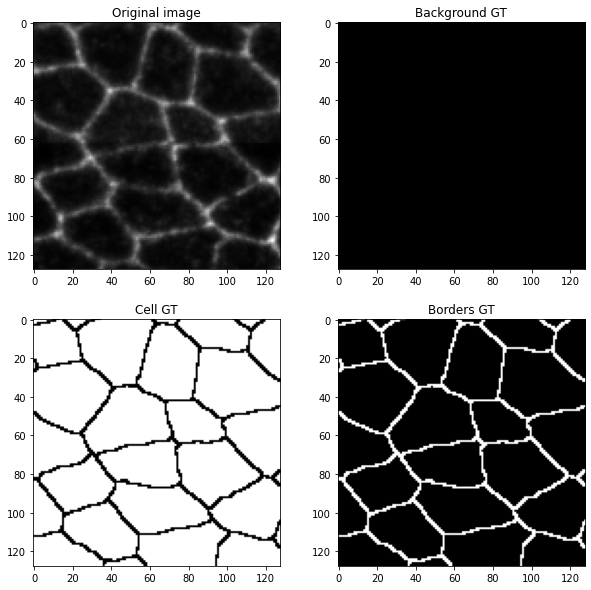

In [20]:
img_num=10

# Display corresponding first 3 patches
plt.figure(figsize=(10,10))
plt.subplot(2,2, 1)
plt.imshow( X_train[img_num][:,:,0], 'gray' )
plt.title( 'Original image' )
plt.subplot(2,2, 2)
plt.imshow( Y_train[img_num][:,:,0], 'gray' )
plt.title( 'Background GT' )
# Side by side with its "ground truth"
plt.subplot(2,2, 3)
plt.imshow( Y_train[img_num][:,:,1], 'gray' )
plt.title( 'Cell GT' )
# prediction for the model trained with 100% data
plt.subplot(2,2, 4)
plt.imshow( Y_train[img_num][:,:,2], 'gray' )
plt.title( 'Borders GT' );

As it is possible to observe the Background GT is empty as in this case all the cells fill the whole image, therefore makes no sense to use it and will only cause the model to train slower and maybe confuse its predictions.

In [21]:
def append_blackborder(img,height,width):
  """ Function to append a blackborder to the images in order to avoid a resizing step that may affect the resolution and pixel size
  """
  new_h=(height-img.shape[0])
  new_w=(width- img.shape[1])
  img = cv2.copyMakeBorder(img ,new_h,0,new_w,0 , cv2.BORDER_CONSTANT) 
  return img
def append_pot2(img):
  """
  Function to append a blackborder but instead of having to specify the shape of the desired image
  the function would check the shape and append a black border in order to obtain an image that is a multiple of 2^n as required by the U-Net Models
  
  """
  new_height=img.shape[0]
  new_width=img.shape[1]
  while new_height%32!=0:
    new_height+=1
  while new_width%32!=0:
    new_width+=1
  img = append_blackborder(img,new_height,new_width)
  #print('An image with shape'+str(img.shape)+'has been created')
  return img

In [22]:
import cv2
X_test = [  np.expand_dims( append_pot2(x), axis=-1 )  for x in test_img ];
Y_test = [  convert_to_oneHot(append_pot2(x))  for x in test_lbl ];

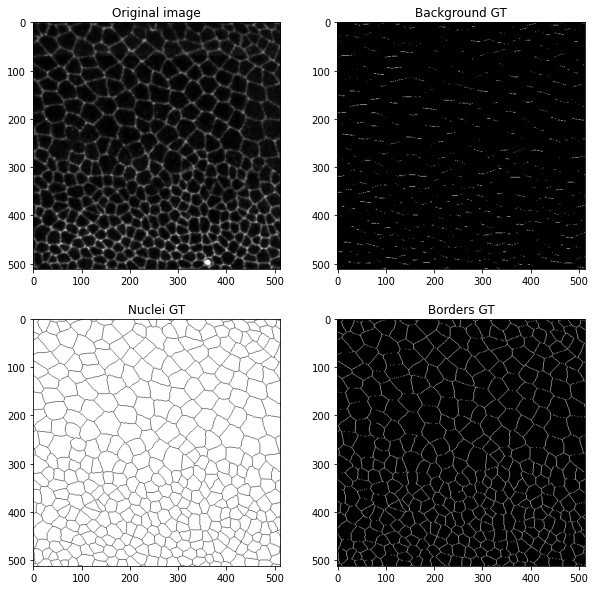

In [23]:
img_num=15

# Display some testing images and its corresponding GT
plt.figure(figsize=(10,10))
plt.subplot(2,2, 1)
plt.imshow( X_test[img_num][:,:,0], 'gray' )
plt.title( 'Original image' )
plt.subplot(2,2, 2)
plt.imshow( Y_test[img_num][:,:,0], 'gray' )
plt.title( 'Background GT' )
# Side by side with its "ground truth"
plt.subplot(2,2, 3)
plt.imshow( Y_test[img_num][:,:,1], 'gray' )
plt.title( 'Nuclei GT' )
# prediction for the model trained with 100% data
plt.subplot(2,2, 4)
plt.imshow( Y_test[img_num][:,:,2], 'gray' )
plt.title( 'Borders GT' );

### Training with 100% labels


| max_pooling   	| activation   	| data_aug   	| loss   	| optimizer   	| lr     	| epochs   	| patience   	| batch_size   	| lr_schedule   	| Loss     	| IoU      	|
|---------------	|--------------	|------------	|--------	|-------------	|--------	|----------	|------------	|--------------	|---------------	|----------	|----------	|
| ------------- 	| ------------ 	| ---------- 	| ------ 	| ----------- 	| ------ 	| -------- 	| ---------- 	| ------------ 	| ------------- 	| -------- 	| -------- 	|
| True          	| ReLu         	| True       	| CCE    	| Adam        	| 0.001  	| 20       	| 20         	| 1            	| oneCycle      	| 0.452778 	| 0.761832 	|
| True          	| ReLu         	| True       	| CCE    	| Adam        	| 0.001  	| 20       	| 20         	| 5            	| oneCycle      	| 0.35424  	| 0.820296 	|
| True          	| ReLu         	| True       	| CCE    	| Adam        	| 0.001  	| 20       	| 20         	| 10           	| oneCycle      	| 0.324802 	| 0.842032 	|
| True          	| ReLu         	| True       	| CCE    	| Adam        	| 0.001  	| 20       	| 20         	| 20           	| oneCycle      	| 0.32357  	| 0.859507 	|
| True          	| ReLu         	| True       	| CCE    	| Adam        	| 0.0001 	| 20       	| 20         	| 1            	| oneCycle      	| 0.409075 	| 0.78623  	|
| True          	| ReLu         	| True       	| CCE    	| Adam        	| 0.0001 	| 20       	| 20         	| 5            	| oneCycle      	| 0.338912 	| 0.763725 	|
| True          	| ReLu         	| True       	| CCE    	| Adam        	| 0.0001 	| 20       	| 20         	| 10           	| oneCycle      	| 0.280246 	| 0.859459 	|
| True          	| ReLu         	| True       	| CCE    	| Adam        	| 0.0001 	| 20       	| 20         	| 20           	| oneCycle      	| 0.321507 	| 0.859509 	|
| True          	| ReLu         	| True       	| CCE    	| SGD         	| 0.001  	| 20       	| 20         	| 1            	| oneCycle      	| 0.346677 	| 0.775059 	|
| True          	| ReLu         	| True       	| CCE    	| SGD         	| 0.001  	| 20       	| 20         	| 5            	| oneCycle      	| 0.308327 	| 0.778355 	|
| True          	| ReLu         	| True       	| CCE    	| SGD         	| 0.001  	| 20       	| 20         	| 10           	| oneCycle      	| 0.282419 	| 0.856432 	|
| True          	| ReLu         	| True       	| CCE    	| SGD         	| 0.001  	| 20       	| 20         	| 20           	| oneCycle      	| 0.366095 	| 0.859507 	|
| True          	| ReLu         	| True       	| CCE    	| SGD         	| 0.0001 	| 20       	| 20         	| 1            	| oneCycle      	| 0.309566 	| 0.787364 	|
| True          	| ReLu         	| True       	| CCE    	| SGD         	| 0.0001 	| 20       	| 20         	| 5            	| oneCycle      	| 0.355833 	| 0.80342  	|
| True          	| ReLu         	| True       	| CCE    	| SGD         	| 0.0001 	| 20       	| 20         	| 10           	| oneCycle      	| 0.440256 	| 0.858669 	|
| True          	| ReLu         	| True       	| CCE    	| SGD         	| 0.0001 	| 20       	| 20         	| 20           	| oneCycle      	| 0.563546 	| 0.859116 	|

### Choose the network's architecture, loss function and train



In [90]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# === Training parameters ===
# number of epochs
numEpochs = 50
# patience
patience = 50#this means that the net won't be stopped before 30 epochs
# learning rate
lr = 1e-3
# batch size
batch_size_value = 20
# use one-cycle policy for super-convergence? Reduce on plateau?
schedule = 'oneCycle' #'oneCycle' # 'reduce' # None
# Network architecture: UNet, ResUNet,MobileNetEncoder
model_name = 'MobileNetEncoder'
# Optimizer name: 'Adam', 'SGD'
optimizer_name = 'Adam'
# Loss function name: 'BCE', 'Dice', 'W_BCE_Dice'
loss_acronym = 'CCE'
# create the network and compile it with its optimizer
max_pooling=True
repetitions=1


In [91]:
# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_train,
                                                          Y_train,
                                                         X_val,Y_val,
                                                          rescale= 1.,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          preprocessing_function=None,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_10 (Functional)           [(None, None, None,  1841408     input_12[0][0]                   
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, None, None, 5 1476608     model_10[0][4]                   
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, None, None, 1 0           sequential_20[0][0]              
                                                                 model_10[0][3]            

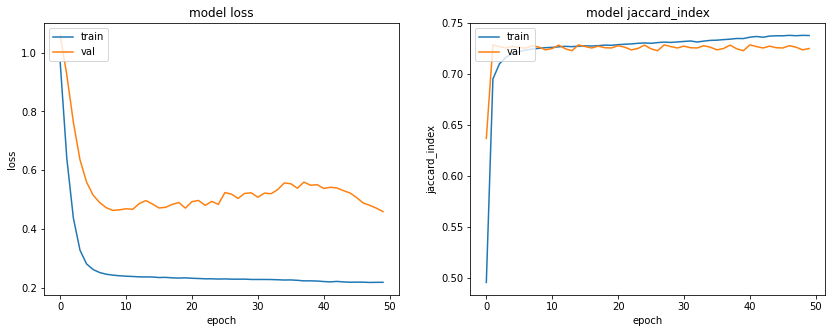


# Evaluate on test data with all training data in loop: 0


IndexError: ignored

In [92]:
results100=[]
for i in range(0,repetitions):
    history,model100=train(numEpochs,patience,lr,batch_size_value,schedule,model_name,optimizer_name,loss_acronym,max_pooling,train_encoder=True,preTrain=False,pre_load_weights=False,plot_history=True)
    # Evaluate the model on the test data using `evaluate`
    print('\n# Evaluate on test data with all training data in loop:',i)
    total_loss=[]
    total_jaccard=[]
   

In [95]:
for i in range(0,42):
      loss,jaccard=model100.evaluate(X_test[i][np.newaxis,:,:,:], Y_test[i][np.newaxis,:,:,:],verbose=0)
      total_loss.append(loss)
      total_jaccard.append(jaccard)
print('The average IoU in test set is: ',np.mean(total_jaccard))


The average IoU in test set is:  0.8162052801677159



 Generate predictions for all models


Text(0.5, 1.0, 'Prediction borders ')

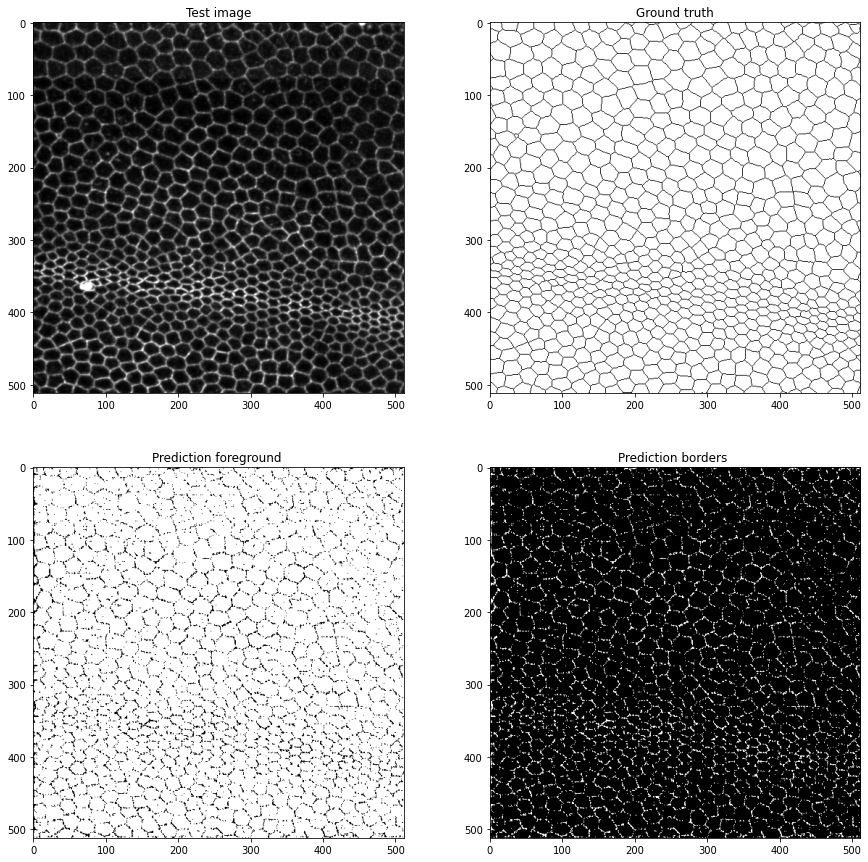

In [97]:
print('\n Generate predictions for all models')
predictions100 = model100.predict(X_test[8][np.newaxis,:,:,:])



# Display corresponding first 3 patches
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.imshow( X_test[8][:,:,0], 'gray' )
plt.title( 'Test image' )
# Side by side with its "ground truth"
plt.subplot(2, 2, 2)
plt.imshow( Y_test[8][:,:,1], 'gray' )
plt.title( 'Ground truth' )
# prediction for the model trained with 100% data
plt.subplot(2, 2, 3)
plt.imshow( tf.math.argmax(predictions100[0,:,:], axis=-1)==1, 'gray' )
plt.title( 'Prediction foreground ' )
plt.subplot(2, 2, 4)
plt.imshow( tf.math.argmax(predictions100[0,:,:], axis=-1)==2, 'gray' )
plt.title( 'Prediction borders ' )


In [98]:
from tabulate import tabulate



# define data generators to do data augmentation (and rescale pixel values
# between 0.0 and 1.0 by dividing by 255)
train_generator, val_generator = get_train_val_generators( X_train,
                                                          Y_train,
                                                         X_val,Y_val,
                                                          rescale= 1.,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          rotation_range = 180,
                                                          #width_shift_range=0.2,
                                                          #height_shift_range=0.2,
                                                          #shear_range=0.2,
                                                          preprocessing_function=None,
                                                          batch_size=batch_size_value,
                                                          show_examples=False )
def grid_create(*itrs):
  import itertools
  grid = list(itertools.product(*itrs))
  return grid
 

def grid_search(max_pooling,activation,data_aug,loss,optimizer,lr,epochs,patience,batch_size,lr_schedule):
  """Inputs:can be a single value or a list of values to be tested with a certain combination of Hyperparameters
       max_pooling(boolean):indicating True if max_pooling must be performed, False if average pooling to be performed
       activation(string): indicating the activation function to be used in the different layers
       data_aug(string): indicating the kind of data_aug
       loss(string): indicating the name of the loss function to be applied 'BCE', 'Dice', 'W_BCE_Dice'
       optimizer(string):indicating the kind of optimized to be used 'Adam', 'SGD'
       lr(float): number indicating the lr starting value
       epochs(int):number of "loops" of training
       patience(int): number of "loops" without improvement till the training is stopped
       batch_size(int):number of images in each step of improvement inside an epoch
       lr_schedule(string):indicating the variations performed in the lr during the training #'oneCycle' # 'reduce' # None
      Output:
      x: grid with the hyperparameters tested and the test IoU results
  """
  x=grid_create(max_pooling,activation,data_aug,loss,optimizer,lr,epochs,patience,batch_size,lr_schedule)
  # === Training parameters===
  # number of epochs
  results=[]
  i=0
  for k in x:
    i+=1
    print("Iteration "+str(i)+" of",len(x))
    max_pooling=k[0]
    activation=k[1]
    data_aug=k[2]
    loss=k[3]
    optimizer=k[4]
    lr=k[5]
    epochs=k[6]
    patience=k[7]
    batch_size=k[8]
    lr_schedule=k[9]
    model_name = 'MobileNetEncoder'
    history,model=train(max_pooling=max_pooling,numEpochs=epochs,patience=patience,lr=lr,batch_size_value=batch_size,schedule=lr_schedule,model_name=model_name,optimizer_name=optimizer,loss_acronym=loss)
    print('\n# Evaluate on test data')
    total_loss=[]
    total_jaccard=[]
    for j in range(0,42):
      loss,jaccard=model.evaluate(X_test[j][np.newaxis,:,:,:], Y_test[j][np.newaxis,:,:,:],verbose=0)
      total_loss.append(loss)
      total_jaccard.append(jaccard)
    results.append([np.mean(total_loss),np.mean(total_jaccard)])
  print(tabulate(x, headers=["max_pooling","activation","data_aug","loss","optimizer","lr","epochs","patience","batch_size","lr_schedule",'Loss',"IoU"]))
  print(tabulate(results, headers=['Loss',"IoU"]))
  return x,results

In [100]:

max_pooling=[True,False];activation=['ReLu'];data_aug=[True];loss=['CCE'];optimizer=['Adam' ];lr=[1e-4,5e-5];epochs=[60];patience=[5,10,40];batch_size=[10,20];lr_schedule=['oneCycle','reduce']
x,results=grid_search(max_pooling,activation,data_aug,loss,optimizer,lr,epochs,patience,batch_size,lr_schedule)



Streaming output truncated to the last 5000 lines.
Epoch 00022: val_loss improved from 0.50614 to 0.49902, saving model to current_model
Epoch 23/60
72/72 [==============================] - 9s 121ms/step - loss: 0.2569 - jaccard_index: 0.7235 - val_loss: 0.5046 - val_jaccard_index: 0.7248

Epoch 00023: val_loss did not improve from 0.49902
Epoch 24/60
72/72 [==============================] - 9s 122ms/step - loss: 0.2565 - jaccard_index: 0.7198 - val_loss: 0.5093 - val_jaccard_index: 0.7229

Epoch 00024: val_loss did not improve from 0.49902
Epoch 25/60
72/72 [==============================] - 9s 122ms/step - loss: 0.2492 - jaccard_index: 0.7247 - val_loss: 0.5011 - val_jaccard_index: 0.7286

Epoch 00025: val_loss did not improve from 0.49902
Epoch 26/60
72/72 [==============================] - 9s 121ms/step - loss: 0.2509 - jaccard_index: 0.7235 - val_loss: 0.5033 - val_jaccard_index: 0.7269

Epoch 00026: val_loss did not improve from 0.49902
Epoch 27/60
72/72 [========================

In [ ]:
max_pooling=[True,False];activation=['ReLu'];data_aug=[True];loss=['CCE'];optimizer=['Adam' ];lr=[5e-4,1e-4];epochs=[20,40];patience=[40];batch_size=[5,10];lr_schedule=['oneCycle','reduce']
x,results=grid_search(max_pooling,activation,data_aug,loss,optimizer,lr,epochs,patience,batch_size,lr_schedule)

